In [1]:
import os.path as op
import warnings

import numpy as np
import pandas as pd
from scipy.signal import correlate, hilbert
import scipy.ndimage as nd

from scipy.signal import butter, lfilter

from utilities import reduce_df_mem_usage

from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
#sns.set()

#sns.set("dark_background")
#sns.set(context="talk")

sns.set(style="ticks", context="talk")
plt.style.use("dark_background")
%matplotlib inline

rand_seed = 1234
rand_state = np.random.RandomState(rand_seed)

warnings.simplefilter(action='ignore', category=FutureWarning)

PATH = '/home/dhren/Documents/000_flatiron/002_projects/006_1028_kaggle_ASHRAE/data'

FIGSIZE = (28, 20)

In [3]:
df_train = reduce_df_mem_usage(pd.read_csv(op.join(PATH, 'train.csv')))
df_train['timestamp'] = pd.to_datetime(df_train['timestamp'])
display(df_train.head())

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01,0.0
1,1,0,2016-01-01,0.0
2,2,0,2016-01-01,0.0
3,3,0,2016-01-01,0.0
4,4,0,2016-01-01,0.0


/opt/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:12: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  if sys.path[0] == '':
/opt/miniconda3/envs/ml/lib/python3.7/site-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log
No handles with labels found to put in legend.


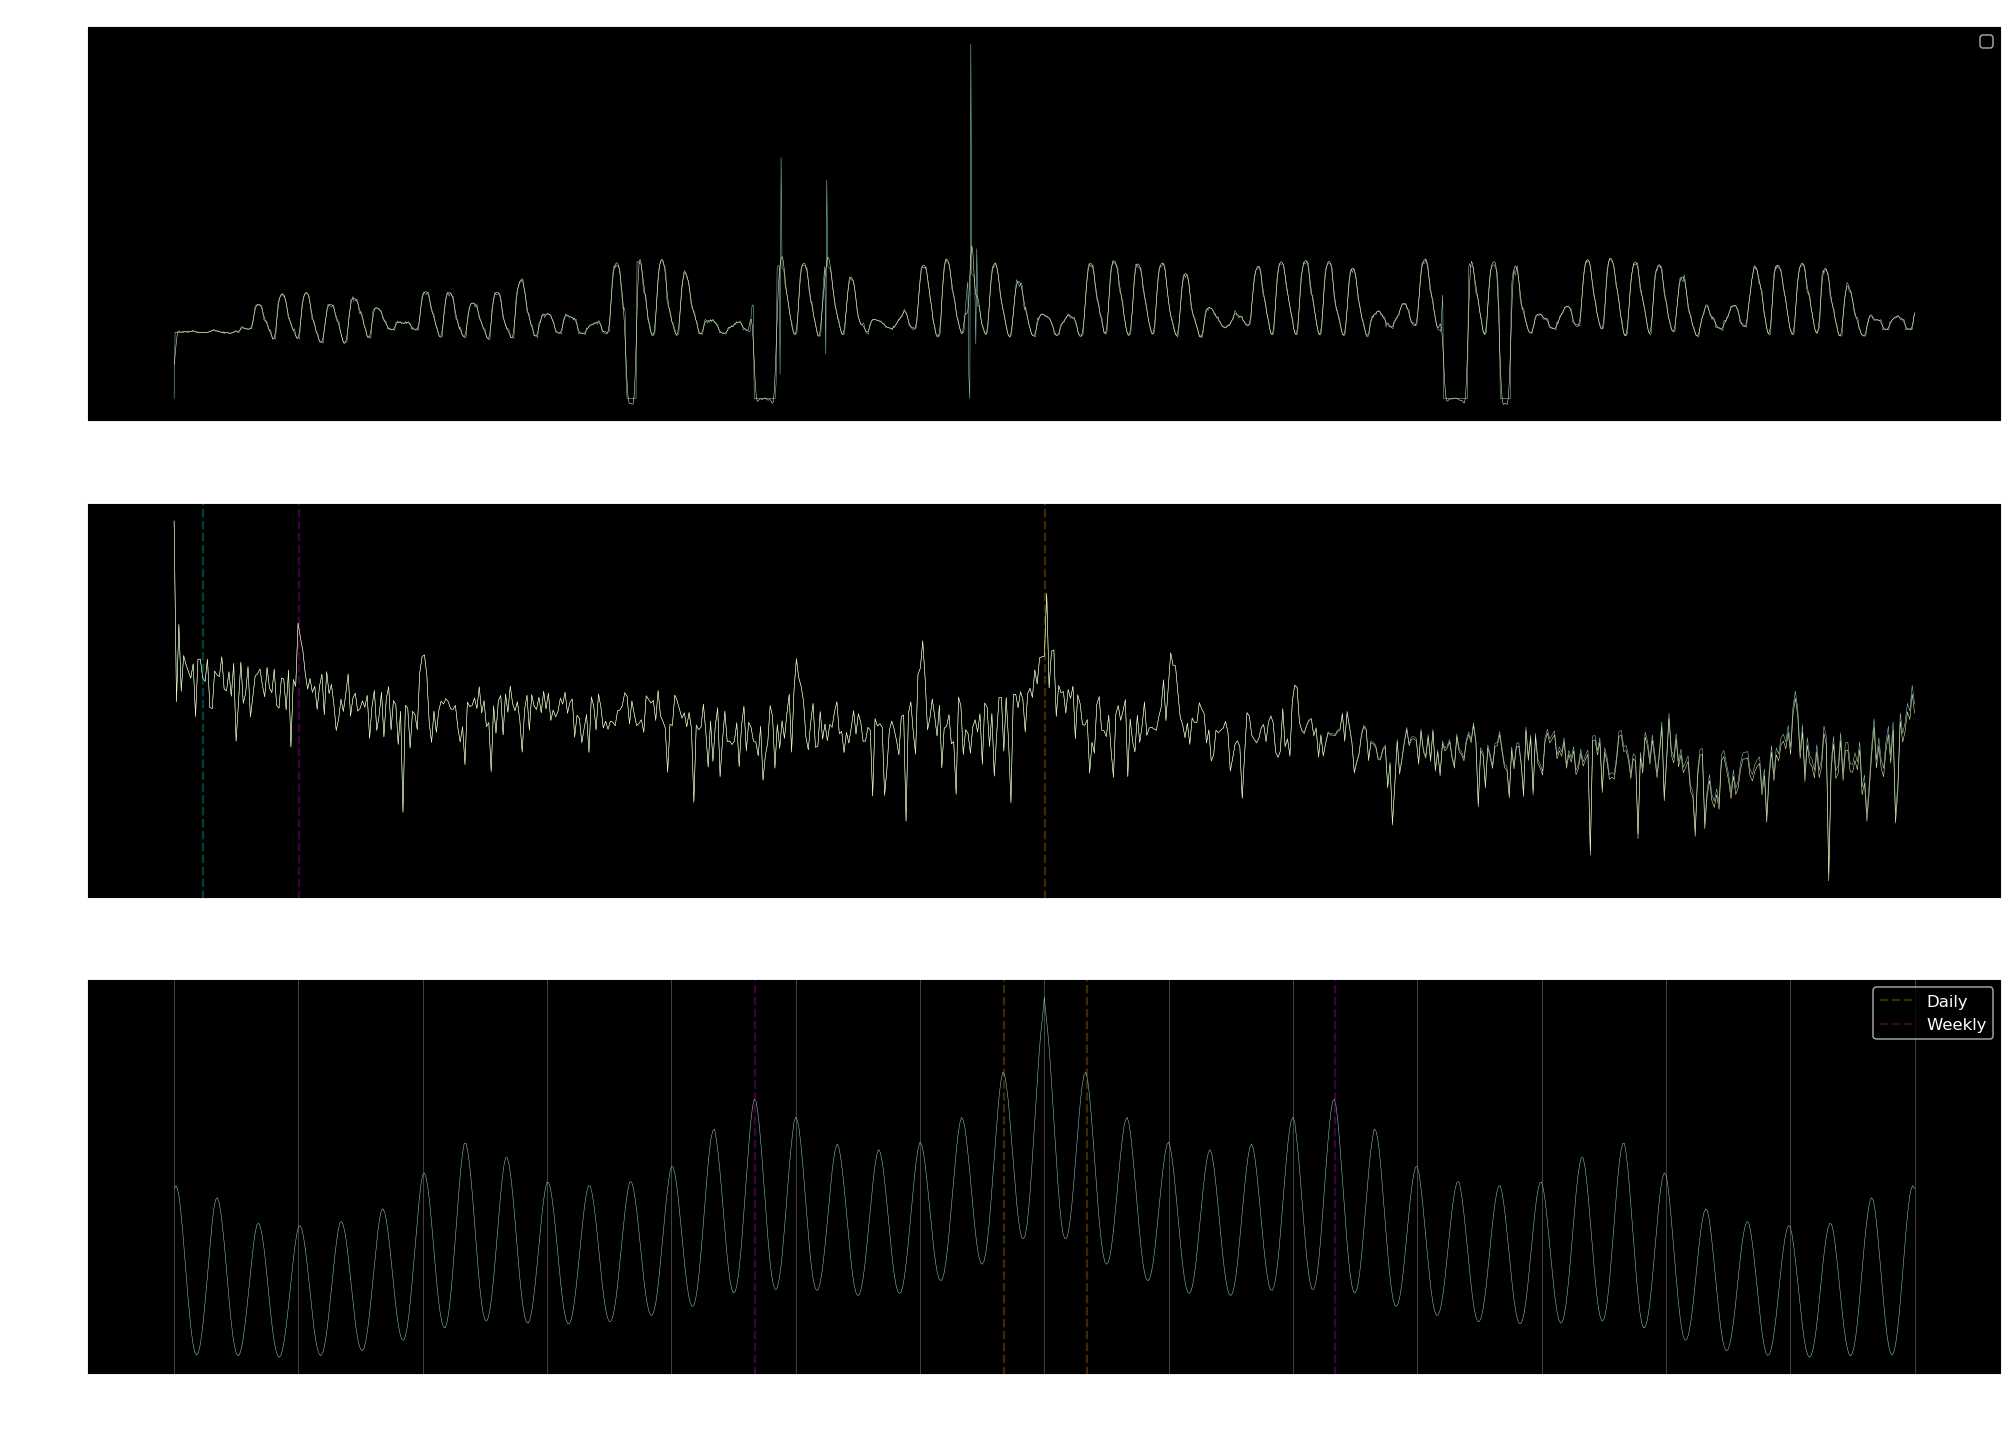

No handles with labels found to put in legend.


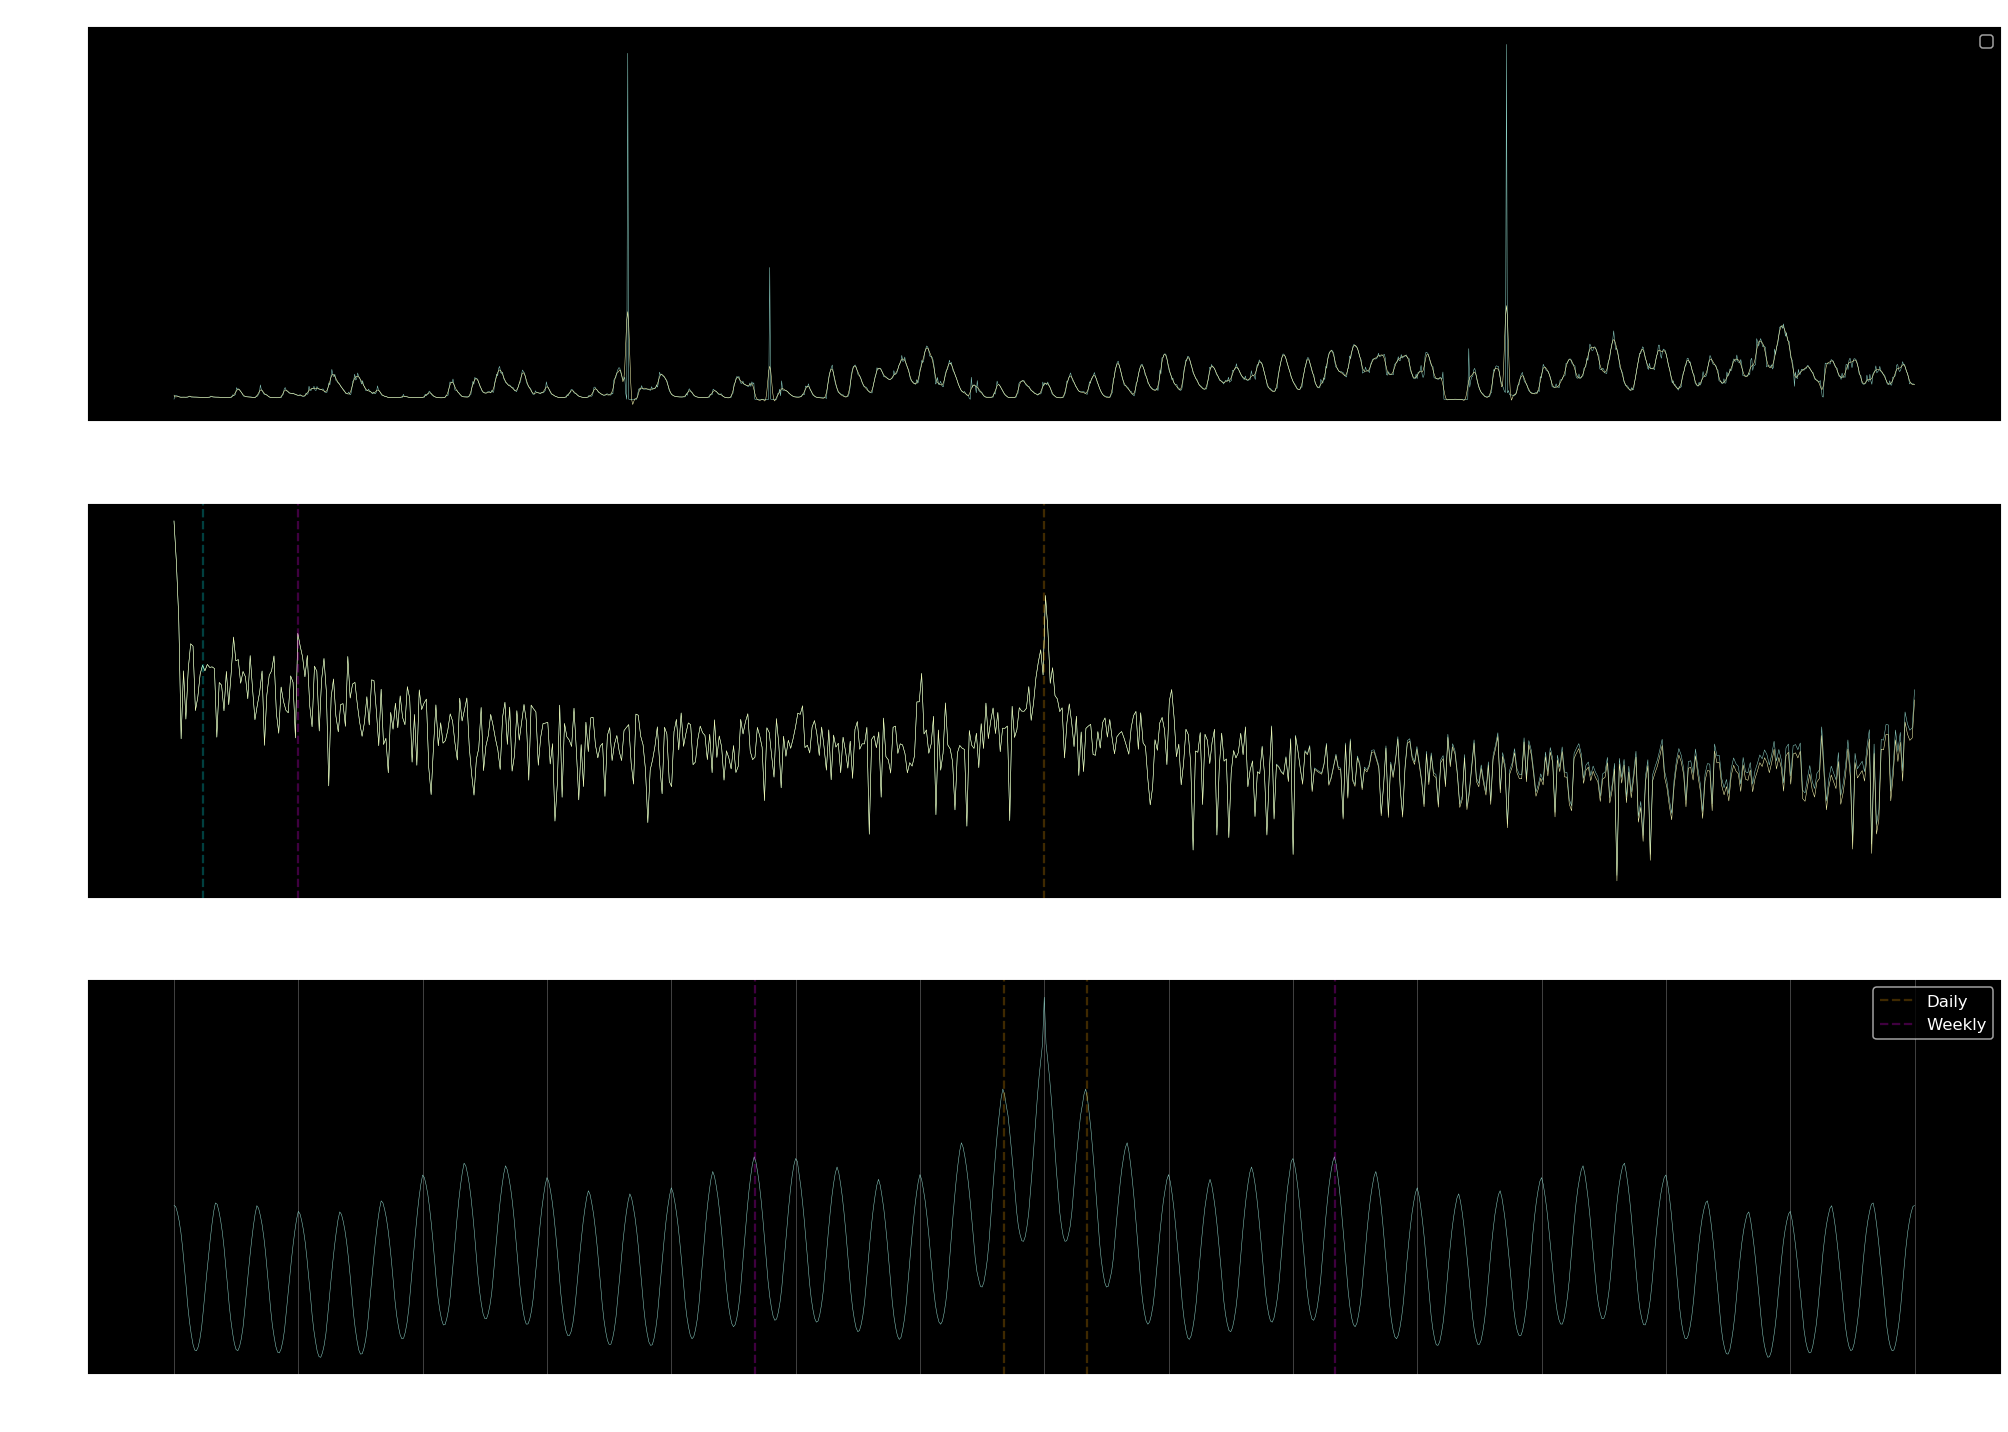

No handles with labels found to put in legend.


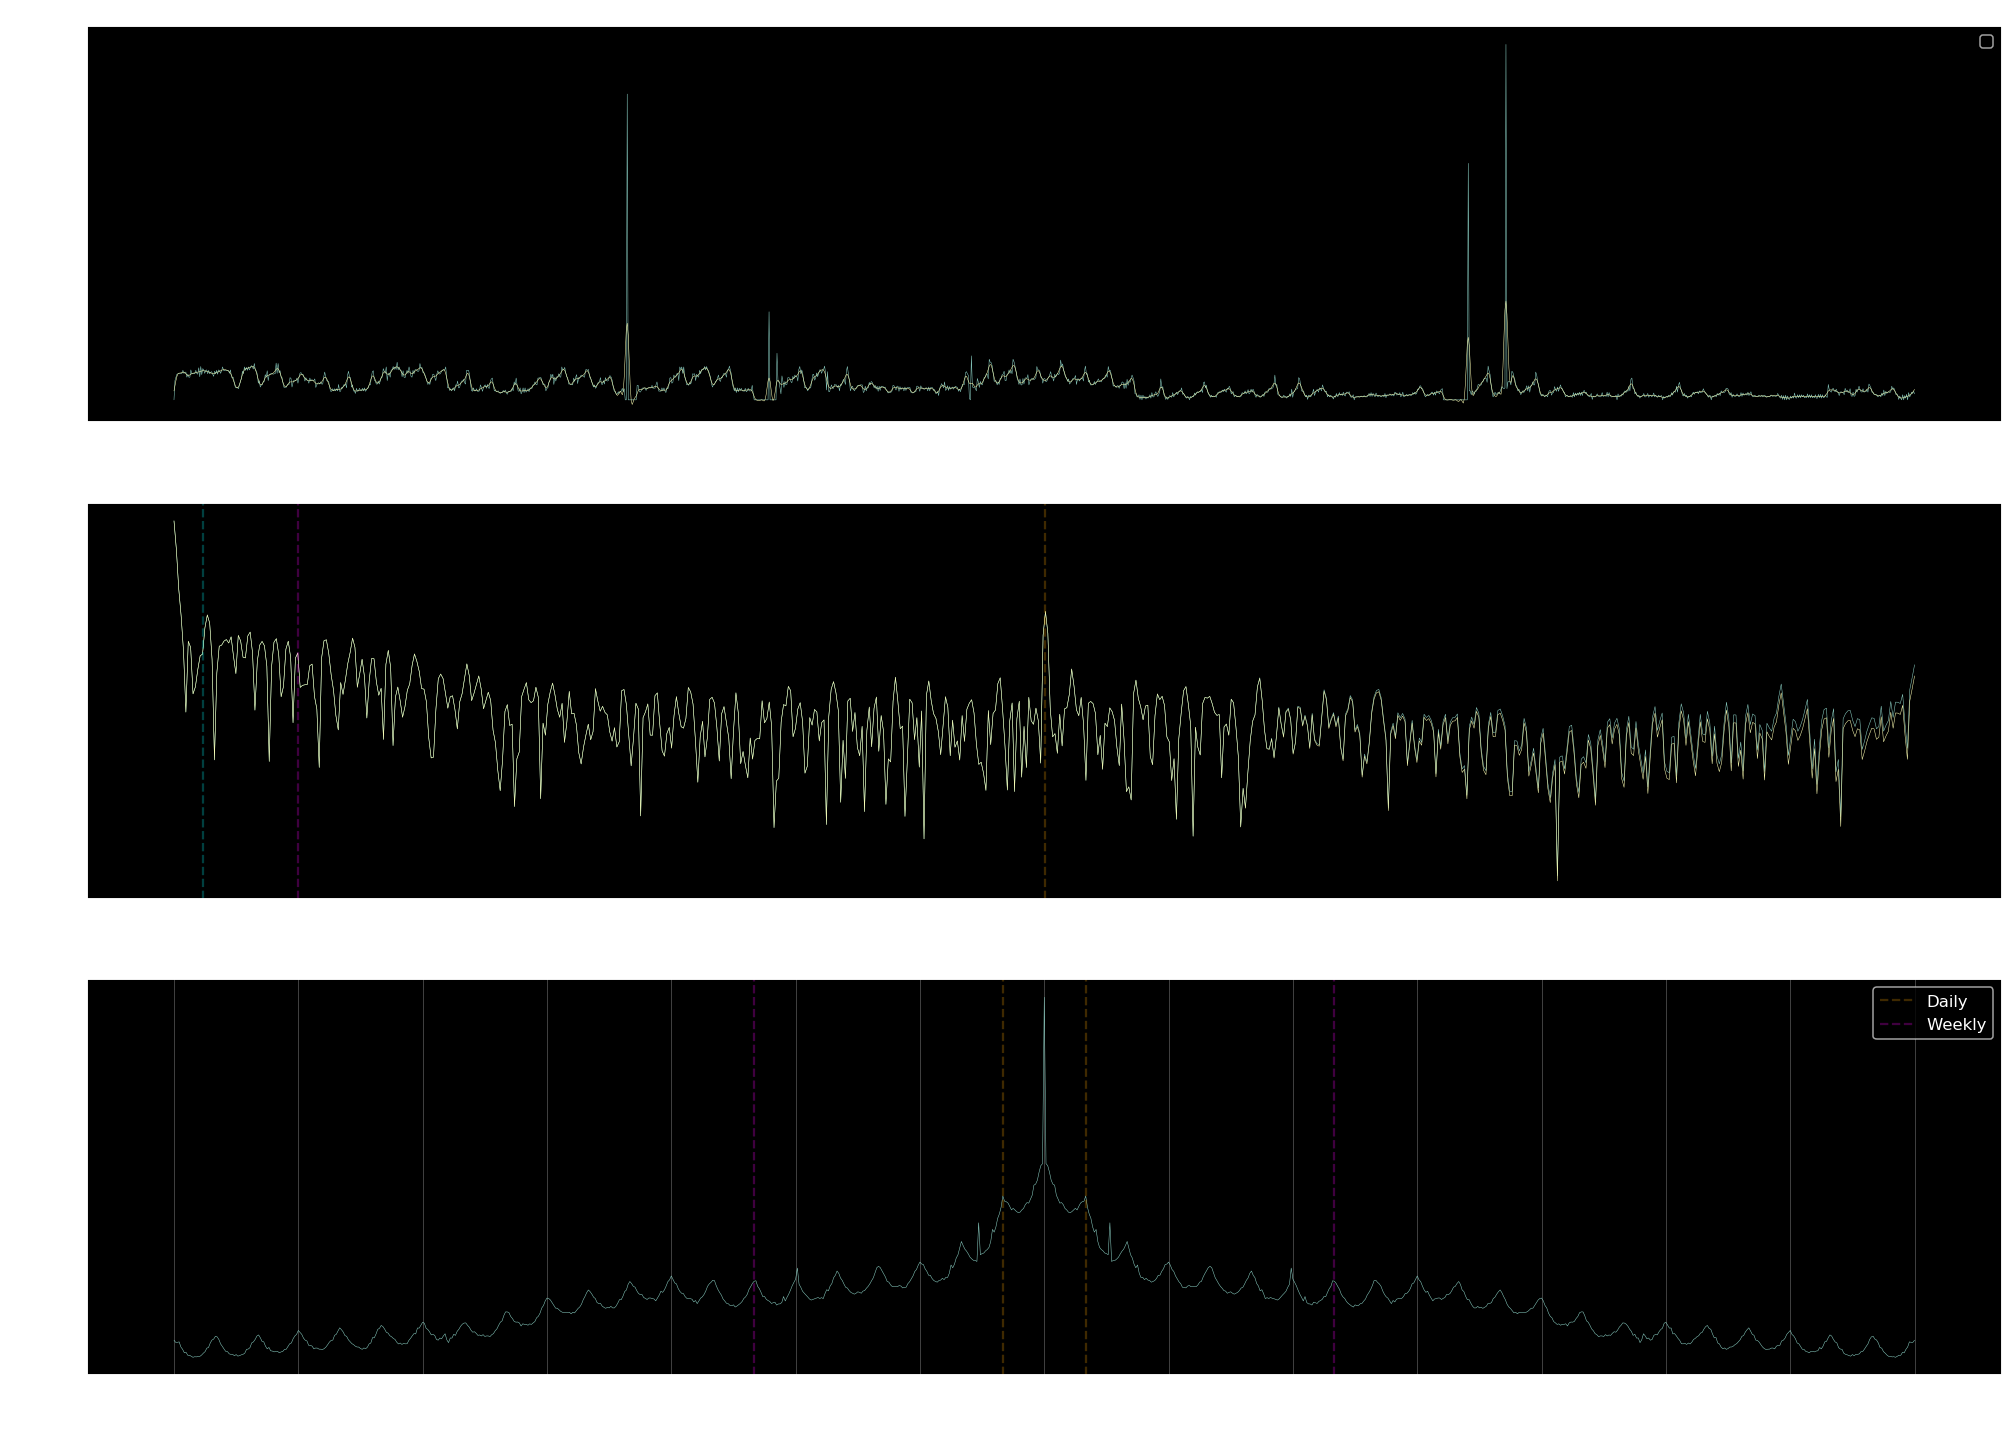

In [40]:
cor_win = 24 * 21 # in hours
ds = 0.001 # psuedo

bids = np.random.choice(df_train.building_id.unique(), size = 10, replace = False)

for bid in [922]:
# for bid in bids:
    df_b = df_train[df_train.building_id == bid]
        
    for mid in df_b.meter.unique():
    
        df_0 = df_b[df_train.meter == mid]

        x = df_0.timestamp
        y = df_0.meter_reading.values.copy()
        
        #a,b = butter(4, 0.5, 'low', analog=False)
        #y_filt = lfilter(b, a, y)
        
        bol = pd.isna(y) | np.where(y == 0, True, False)
        med = np.median(y[~bol])

        #y[bol] = np.median(y[~bol])

        freq = np.fft.rfftfreq(len(y) + 1, ds)
        freq_bol = freq <= 2 * 1000./(24.)

        y_fft = np.fft.rfft(np.pad(y, (0,1), mode = 'constant'))
        spec = 20 * np.log(np.abs(y_fft) / np.abs(y_fft).max())
        phase = np.unwrap(np.angle(y_fft))

        y_filt_fft = y_fft * np.interp(freq, [0., 50., 200., 500.], [1., 1., 0., 0.])
        
        y_filt = np.fft.irfft(y_filt_fft)[:-1]
        
        spec_filt = 20 * np.log(np.abs(y_filt_fft) / np.abs(y_filt_fft).max())
        phase_filt = np.unwrap(np.angle(y_filt_fft))

        corr = correlate(y, y, 'same')

        corr_sm = nd.uniform_filter(corr, 151, mode = 'nearest')
        env = np.abs(hilbert(corr - corr_sm)) + corr_sm


        corr_lag = np.arange(y.size) - y.size / 2

        corr_slc = slice(len(corr) // 2 - cor_win, len(corr) // 2 + cor_win + 1)

        fig = plt.figure(figsize = FIGSIZE)
        
        plt.subplot(3,1,1)
        plt.plot(y[:y.size//5], linewidth = 0.5)
        plt.plot(y_filt[:y.size//5], linewidth = 0.5)

#         plt.plot(x, df_0.meter_reading.values, linewidth = 0.5)
#         plt.plot(x, y_filt, linewidth = 0.5)
#         plt.plot(x, np.ones(len(y), dtype = 'f2') * med, 'red', alpha = 0.25, linestyle = "--", label = "Median")

        plt.title("Meter Reading, Building ID: {}, Meter ID: {}".format(bid, mid))
        plt.xlabel("Date/Time")
        plt.ylabel("kWh")
        plt.legend()

        plt.subplot(3,1,2)
        plt.plot(freq[freq_bol], spec[freq_bol], linewidth = 0.5)
        plt.plot(freq[freq_bol], spec_filt[freq_bol], linewidth = 0.5)

        plt.axvline(x = 1000./(24.), color = 'orange', alpha = 0.25, linestyle = '--')
        plt.axvline(x = 1000./(24. * 7.), color = 'magenta', alpha = 0.25, linestyle = '--')
        plt.axvline(x = 1000./(24. * 30.), color = 'cyan', alpha = 0.25, linestyle = '--')

        plt.title("Spectrum (Amplitude)")
        plt.xticks([1000./(24. * 30.), 1000./(24. * 7.), 1000./(24.), 1000./(12.)], ["Monthly", "Weekly", "Daily", "12 Hours"])
        plt.ylabel("Amplitude (dB)")
        plt.xlabel("Frequency")

        plt.subplot(3,1,3)

        plt.plot(corr_lag[corr_slc], corr[corr_slc], linewidth = 0.5)

        plt.axvline(x = 24, color = 'orange', alpha = 0.25, linestyle = '--', label = "Daily")
        plt.axvline(x = -24, color = 'orange', alpha = 0.25, linestyle = '--')

        plt.axvline(x = 24 * 7, color = 'magenta', alpha = 0.25, linestyle = '--', label = "Weekly")
        plt.axvline(x = -24 * 7, color = 'magenta', alpha = 0.25, linestyle = '--')

        plt.xticks(corr_lag[corr_slc][::72], list(map(lambda x : "{:d} Days".format(x), (corr_lag[corr_slc][::72] / 24).astype('int'))))
        plt.grid(axis = 'x', linewidth = 1.0, alpha = 0.25)
        
        plt.title("Auto-correlation")
        plt.xlabel("Lag")
        plt.ylabel("Correlation Coefficient")
        plt.legend()

        plt.tight_layout()
        plt.show()